Copyright 2023 DeepMind Technologies Limited.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# **Simulated Asynchronous Local-SGD (Toy Example)**

In this notebook, we will go over a simple example of simulating asynchronous local-sgd for solving classification of clusters of mixture of Gaussians. This
toy example aims to:
1. Provide an example of how asynchronous local-sgd works,
simulating workers operating at different speeds, and testing various methods under staled updates.
2. Mimic the optimization challenges found when training language models using asynchronous local-sgd.
3. Provide several baseline methods and tools to analyze this challenging learning setting.

## **Pseudocode for Simulated Asynchronous Task Scheduling**


#### **Asynchronous Simulation**
```
train()  # Start the first round of training for all workers.

while not finished():
  next_worker = get_next_sync_worker()

  if next_worker:
    concurrent.futures.wait([next_worker.future])

  if next_worker and synchronizable():
    synchronize(next_worker)
  else:
    train()
```
#### **Synchronous Simulation**
```
while not finished():
  train()
  synchronize()
```

# Local-SGD Simulation Code

In [ ]:
import concurrent.futures as futures
import copy
import math
import numpy as np
import random
import time
import torch
import torch.nn as nn

from typing import Optional, Any
from torch.utils.data import DataLoader


def seeding(seed):
  # Control randomness
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  np.random.seed(seed)
  torch.backends.cudnn.deterministic = True

DEVICE = "cuda"

### Data Generation

In [ ]:
seeding(42)

class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    self.X = torch.Tensor(X)
    self.Y = torch.LongTensor(Y)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    x = self.X[idx]
    y = self.Y[idx]
    return x, y


ep = .5
CLUSTERS_PER_CLASS = 8
D = 512
NUM_CLASSES = 4
BATCHSIZE = 32
NUM_DATA = 128000  # Data need to be large enough to see orthogonal pseudo-gradients
NUM_DATA_SMALL = 4096
NUM_WORKERS = 4
NUM_DATA_SHARDS = 4
assert NUM_WORKERS == NUM_DATA_SHARDS  # For now, we assume they are the same


def make_data(N, clusters_per_class, num_classes):
  # DATA consists of a mixture of CLUSTERS_PER_CLASS*NUM_CLASSES Gaussians. Each
  # Gaussian is assigned to one of the NUM_CLASSES classes; they are distributed
  # amongst the NUM_MODELS clusters evenly. Here, N is the total number of
  # generated examples.
  K = clusters_per_class*num_classes
  n_per_cluster = N//K
  n_per_class = n_per_cluster * clusters_per_class
  centers = np.random.randn(K, D)
  centers = centers/np.linalg.norm(centers, axis=1, keepdims=True)
  X = np.concatenate([ep*np.random.randn(n_per_cluster, D) + centers[i].reshape(1, -1) for i in range(K)])
  Y = np.concatenate([i*np.ones(n_per_class, dtype='int32') for i in range(num_classes)])
  return X, Y


### Create Large-scale Dataset
X, Y = make_data(NUM_DATA, CLUSTERS_PER_CLASS, NUM_CLASSES)
# Create iid clusters
total_indices = list(range(len(X)))
random.shuffle(total_indices)

cluster_size = len(total_indices) // NUM_DATA_SHARDS
cluster_indices_iid = [total_indices[i*cluster_size: (i+1)*cluster_size] for i in range(NUM_DATA_SHARDS)]

eval_indices = list(range(len(X)))
random.shuffle(eval_indices)
eval_indices = eval_indices[:10000]

### Create Small-scale Dataset
X_, Y_ = make_data(NUM_DATA_SMALL, 1, NUM_CLASSES)
# Create iid clusters
total_indices_small = list(range(len(X_)))
random.shuffle(total_indices_small)
cluster_size_small = len(total_indices_small) // NUM_DATA_SHARDS
cluster_indices_iid_small = [total_indices_small[i*cluster_size_small: (i+1)*cluster_size_small] for i in range(NUM_DATA_SHARDS)]

eval_indices_small = list(range(len(X_)))
random.shuffle(eval_indices_small)

### Local-SGD Code

In [ ]:
################################################################################
#
# Model Specification
#
################################################################################

class Model(nn.Module):
  def __init__(self, hidden_size=65000):
    super().__init__()
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(D, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, NUM_CLASSES)
    )

  def forward(self, x):
    return self.net(x)


################################################################################
#
# Helper Class
#
################################################################################


class Worker:
  worker_id: int
  device_sec_per_step: float
  future: Optional[futures.Future[Any]] = None
  model_id: int
  data_id: int
  num_train_steps: int
  training_finished_time: float = 0.0


class Data:
  data_id: int
  visit_times: int = 0
  local_updates: int = 0


class Experiment:
  def __init__(self,
               data_mode: str = 'big',
               model_hidden_size=65000,
               default_inner_steps=20,
               total_phases=400,
               eval_every=10,
               lr_schedule='cosine',
               seed=42,
               inner_opt_name='adamw',
               outer_opt_name='nesterov',
               inner_opt_kwargs={'lr': 2e-4, 'weight_decay': 1e-3, 'betas': (0.9, 0.999)},
               outer_opt_kwargs={'lr': 0.1, 'nesterov': True, 'momentum': 0.9},
               verbose=False):
    self.default_inner_steps = default_inner_steps
    self.eval_interval = self.default_inner_steps * NUM_WORKERS * eval_every
    self.total_phases = total_phases
    self.max_local_updates = self.default_inner_steps * NUM_WORKERS * total_phases
    self.max_local_updates_per_data = self.default_inner_steps * total_phases
    self.eval_target_step = 0

    self.inner_opt_name = inner_opt_name
    self.inner_opt_kwargs = inner_opt_kwargs
    self.outer_opt_name = outer_opt_name
    self.outer_opt_kwargs = outer_opt_kwargs

    self.verbose = verbose
    self.sync_time = 0.0
    self.lr_schedule = lr_schedule
    self.model_hidden_size = model_hidden_size
    self.data_mode = data_mode
    self.seed = seed
    self.initialize()

  def get_experiment_name(self):
    opt_string = f"{self.outer_opt_name}-{self.inner_opt_name}"
    return opt_string

  def finished(self):
    # We terminate if the total steps across all workers is beyond threshold
    return self.num_total_local_updates >= self.max_local_updates

  def initialize(self):
    seeding(self.seed)
    print(f"\n[info] Starting experiment {self.get_experiment_name()} ...",
          flush=True)
    self.model_id = 0
    self.time_now = 0.0
    self.sync_start_time = None
    self.num_total_local_updates = 0
    self.stats = []  # Keep track of train/eval stats

    # Define workers
    self.workers = []
    sec_per_steps = [0.58, 0.75, 1.51, 3.33]
    for worker_id in range(NUM_WORKERS):
      w = Worker()
      w.worker_id = worker_id
      w.device_sec_per_step = sec_per_steps[worker_id]
      self.workers.append(w)

    # Define data shards
    if self.data_mode == 'small':
      eval_dataset = Dataset(X_[eval_indices_small], Y_[eval_indices_small])
      datasets = []
      for i in range(NUM_DATA_SHARDS):
        datasets.append(
            Dataset(X_[cluster_indices_iid_small[i]], Y_[cluster_indices_iid_small[i]])
        )
    elif self.data_mode == 'big':
      eval_dataset = Dataset(X[eval_indices], Y[eval_indices])
      datasets = []
      for i in range(NUM_DATA_SHARDS):
        datasets.append(
            Dataset(X[cluster_indices_iid[i]], Y[cluster_indices_iid[i]])
        )
    else:
      raise ValueError(f"Unknown data mode: {self.data_mode}")

    self.data_shards = []
    for data_id in range(NUM_DATA_SHARDS):
      d = Data()
      d.data_id = data_id
      self.data_shards.append(d)

    def get_train_indices(dataset):
      n = len(dataset)
      repeat_times = max(self.max_local_updates_per_data*BATCHSIZE // n * 2, 1)  # <-- WHY *2?
      indices = []
      for i in range(repeat_times):
        x = np.arange(n)
        random.shuffle(x)
        indices.append(x)
      indices = np.concatenate(indices)
      return indices

    self.datasets = datasets
    # train_indices are for controlling randomness, and data loading
    self.train_indices = [
        get_train_indices(dataset) for dataset in self.datasets
    ]
    self.eval_data_loader = DataLoader(eval_dataset,
                                       batch_size=256,
                                       shuffle=False)
    # Define task writer
    self.train_writer = futures.ThreadPoolExecutor(max_workers=NUM_WORKERS)
    # Define the model on the server
    self.server_model = Model(hidden_size=self.model_hidden_size)
    self.server_model.to(DEVICE)

    # Define the outer optimizer
    self.server_optimizer = get_optimizer(self.server_model.parameters(),
                                          self.outer_opt_name,
                                          self.outer_opt_kwargs)

  def close(self):
    futures.wait([w.future for w in self.workers if w.future and not w.future.done()])
    self.train_writer.shutdown()
    del self.eval_data_loader
    del self.server_model
    del self.server_optimizer
    return

  def evaluate(self):
    if self.num_total_local_updates >= min(self.eval_target_step, self.max_local_updates):
      self.eval_target_step += self.eval_interval

      self.server_model.eval()
      correct = 0
      test_loss = 0
      criterion = nn.CrossEntropyLoss(reduction='sum')
      counter = 0
      with torch.no_grad():
        for data, target in self.eval_data_loader:
          data, target = data.to(DEVICE), target.to(DEVICE)  # Move data to GPU
          output = self.server_model(data)
          test_loss += criterion(output, target).item()
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()
          counter += data.shape[0]
      test_loss /= counter
      test_accuracy = correct / counter
      # Record the test statistics
      self.stats.append((self.num_total_local_updates,
                         test_loss,
                         test_accuracy,
                         self.time_now))
      if self.verbose:
        print(f"[info] step {self.num_total_local_updates:6d} | "
              f"time {self.time_now:10.2f} | acc {test_accuracy:4.2f} | "
              f"loss {test_loss:.6f}", flush=True)
    return


################################################################################
#
# Local-SGD related helper functions
#
################################################################################


def get_momentum_vec(optimizer):
  sd = optimizer.state_dict()['state']
  m_list = []
  for state in sd.keys():
    m_list.append(sd[state]['momentum_buffer'].reshape(-1).detach().cpu().numpy())
  m = np.concatenate(m_list)
  return m


def sample_data(data_shards):
  # We sample the data shard that has been visited least.
  visit_times = np.array([d.visit_times for d in data_shards])
  min_visit = np.min(visit_times)
  min_indices = np.where(visit_times == min_visit)[0]
  data_id = np.random.choice(min_indices)
  return data_shards[data_id].data_id


def sample_train_task(worker, experiment, train_steps, scale_steps=False):
  data_id = sample_data(experiment.data_shards)
  worker.data_id = data_id
  experiment.data_shards[data_id].visit_times += 1

  if not scale_steps:
    worker.num_train_steps = train_steps
  else:  # Let slower worker run fewer steps to remove staleness
    c = min([w.device_sec_per_step for w in workers]) / worker.device_sec_per_step
    worker.num_train_steps = max(int(train_steps * c), 5)

  worker.training_finished_time += worker.num_train_steps * worker.device_sec_per_step
  experiment.data_shards[data_id].local_updates += worker.num_train_steps
  worker.model_id = experiment.model_id
  return data_id


class CosineScheduler:
  def __init__(self, optimizer, peak_lr, T_max, last_epoch=-1, eta_min=1e-6):
    self.last_epoch = last_epoch
    self.total_epochs = T_max
    self.peak_lr = peak_lr
    self.eta_min = eta_min
    self.optimizer = optimizer

  def step(self):
    self.last_epoch += 1
    progress = min(self.last_epoch / self.total_epochs, 1.0)
    lr = self.eta_min + (self.peak_lr-self.eta_min) * 0.5 * (1 + math.cos(math.pi * progress))
    for param_group in self.optimizer.param_groups:
      param_group['lr'] = lr


def get_optimizer(params, opt_name, opt_kwargs):
  opt = {
      'adamw': torch.optim.AdamW,
      'sgd': torch.optim.SGD,
      'sgd_momentum': torch.optim.SGD,
      'nesterov': torch.optim.SGD,
  }
  return opt[opt_name](params, **opt_kwargs)


################################################################################
#
# Client-side Optimization
#
################################################################################


def inner_loop(local_model,
               dataset,
               train_indices,
               train_steps,
               lr_schedule,
               local_updates,
               total_updates,
               opt_name,
               opt_kwargs):

  local_model.train()
  initial_state = [p.clone().data for p in local_model.parameters()]

  optimizer = get_optimizer(local_model.parameters(), opt_name, opt_kwargs)

  if lr_schedule == 'cosine':
    lr_scheduler = CosineScheduler(
        optimizer,
        peak_lr=2e-4,
        T_max=total_updates,
        last_epoch=local_updates - train_steps,
        eta_min=1e-6,
    )
  else:
    lr_scheduler = None

  step = 0
  criterion = nn.CrossEntropyLoss()

  # Avoid using dataloader for reproducibility
  begin_updates = local_updates - train_steps
  for idx in range(begin_updates, local_updates):
    indices = train_indices[idx*BATCHSIZE:(idx+1)*BATCHSIZE]
    data, target = dataset.X[indices], dataset.Y[indices]
    data = torch.Tensor(data).to(DEVICE)
    target = torch.LongTensor(target).to(DEVICE)
    optimizer.zero_grad()
    output = local_model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if lr_scheduler: lr_scheduler.step()

  pseudo_gradient = [
      (init - final.data).clone().data
      for init, final in zip(initial_state, local_model.parameters())
  ]
  return {'pseudo_gradient': pseudo_gradient}


################################################################################
#
# Sync Experiment
#
################################################################################


class SyncExperiment(Experiment):
  def __init__(self, record_cossim_every=20, record_cossim=False, **kwargs):
    self.record_cossim_every = record_cossim_every
    self.record_cossim = record_cossim
    self.cossims = []
    super().__init__(**kwargs)

  def get_experiment_name(self):
    string = super().get_experiment_name()
    return f"sync-{string}"

  def synchronize(self, pseudo_gradients):
    # update the time and total train steps
    for w in self.workers:
      self.time_now = max(self.time_now, w.training_finished_time)
      self.num_total_local_updates += w.num_train_steps
      self.time_now += self.sync_time

    # sync the model
    sync_gradient = [sum(vs) / NUM_WORKERS for vs in zip(*pseudo_gradients)]

    # apply update
    self.server_optimizer.zero_grad()
    for p, g in zip(self.server_model.parameters(), sync_gradient):
      p.grad = g.data.clone()
    self.server_optimizer.step()

    for w in self.workers:
      w.training_finished_time = self.time_now  # sync the time
    self.model_id += 1

  def train(self):
    pseudo_gradients = []
    for w in self.workers:
      data_id = sample_train_task(w,
                                  self,
                                  self.default_inner_steps)
      local_model = copy.deepcopy(self.server_model)
      w.future = self.train_writer.submit(inner_loop,
                                          local_model,
                                          self.datasets[data_id],
                                          self.train_indices[data_id],
                                          self.default_inner_steps,
                                          self.lr_schedule,
                                          self.data_shards[data_id].local_updates,
                                          self.max_local_updates_per_data,
                                          self.inner_opt_name,
                                          self.inner_opt_kwargs)

    pseudo_gradients = [None] * NUM_WORKERS
    futures.wait([w.future for w in self.workers])
    for w in self.workers:
      pseudo_gradients[w.worker_id] = w.future.result()['pseudo_gradient']
    return pseudo_gradients

  def cossim(self, pseudo_gradients):
    pgs = torch.vstack(
      [
        torch.cat([x.view(-1) for x in pseudo_gradient])
        for pseudo_gradient in pseudo_gradients
      ]
    )
    normed = pgs / pgs.norm(dim=1)[:, None]
    sim_matrix = torch.mm(normed, normed.t())
    sim_matrix_np = sim_matrix.cpu().numpy()
    return sim_matrix_np

  def run(self):
    self.evaluate()

    while not self.finished():
      pseudo_gradients = self.train()
      if self.model_id % self.record_cossim_every == 0 and self.record_cossim:
        self.cossims.append((self.num_total_local_updates, self.cossim(pseudo_gradients)))
      self.synchronize(pseudo_gradients)
      self.evaluate()

    self.close()


################################################################################
#
# Async Experiment
#
################################################################################


class AsyncExperiment(Experiment):
  def __init__(self, sync_method='vanilla', sync_weight_method='constant', max_wait_time=0.5, **kwargs):
    self.sync_method = sync_method
    self.sync_weight_method = sync_weight_method
    self.max_wait_time = max_wait_time
    super().__init__(**kwargs)

  def get_experiment_name(self):
    string = super().get_experiment_name()
    if self.max_wait_time > 0:
      return f"async-{string}-sync_method={self.sync_method}-weight_method={self.sync_weight_method}"
    else:
      return f"async-{string}-sync_method={self.sync_method}-weight_method={self.sync_weight_method}-nowait"

  def synchronizable(self):
    return (not self.sync_start_time) or (
        self.time_now - self.sync_start_time <= self.max_wait_time
    )

  def get_next_sync_worker(self):
    if all(not w.future for w in self.workers): return None  # Just synced all models

    wid = np.argmin(
        np.array([
          w.training_finished_time if w.future else np.inf
          for w in self.workers
        ])
    )
    w = self.workers[wid]
    if (
        self.sync_start_time
        and (w.training_finished_time - self.sync_start_time)
        > self.max_wait_time
    ):  # Outside the grace period, do not wait for it.
      return None
    return w

  def get_sync_weight(self, staleness):
    K = len(self.workers)
    base = np.sqrt(K) / K
    if self.sync_weight_method == 'constant':
      return base
    elif self.sync_weight_method == 'polynomial':
      return base * 1 / (1 + staleness)**0.5
    else:
      raise ValueError(f'Unknown sync_weight_method: {self.sync_weight_method}')

  def vanilla(self, pseudo_gradient, sync_weight):
    self.server_optimizer.zero_grad()
    for p, g in zip(self.server_model.parameters(), pseudo_gradient):
      p.grad = sync_weight * g.data.clone()
    self.server_optimizer.step()
    return

  def delayed_sgd(self, pseudo_gradient, sync_weight):
    if self.model_id % NUM_WORKERS == 0:
      self.server_optimizer.zero_grad()
    for p, g in zip(self.server_model.parameters(), pseudo_gradient):
      if p.grad is None:
        p.grad = (1/NUM_WORKERS) * g.data.clone()
      else:
        p.grad += (1/NUM_WORKERS) * g.data.clone()
    if (self.model_id + 1) % NUM_WORKERS == 0:
      self.server_optimizer.step()
    return

  def synchronize(self, w):
    self.sync_start_time = self.sync_start_time or self.time_now
    staleness = (self.model_id - w.model_id)
    self.num_total_local_updates += w.num_train_steps
    # Sync the model
    sync_weight = self.get_sync_weight(staleness)
    pseudo_gradient = w.future.result()['pseudo_gradient']

    if self.sync_method == 'vanilla':
      self.vanilla(pseudo_gradient, sync_weight)
    elif self.sync_method == 'delayed_sgd':
      self.delayed_sgd(pseudo_gradient, sync_weight)

    self.model_id += 1
    self.time_now += self.sync_time
    w.future = None  # Reset this worker's future
    for w_ in self.workers:
      if w_.future is None: w_.training_finished_time = self.time_now

  def train(self):
    for w in self.workers:
      if w.future is None:
        data_id = sample_train_task(w,
                                    self,
                                    self.default_inner_steps)
        local_model = copy.deepcopy(self.server_model)
        w.future = self.train_writer.submit(inner_loop,
                                            local_model,
                                            self.datasets[data_id],
                                            self.train_indices[data_id],
                                            self.default_inner_steps,
                                            self.lr_schedule,
                                            self.data_shards[data_id].local_updates,
                                            self.max_local_updates_per_data,
                                            self.inner_opt_name,
                                            self.inner_opt_kwargs)
    return

  def run(self):
    # Initial round of training
    self.evaluate()
    self.train()

    while not self.finished():
      next_worker = self.get_next_sync_worker()

      if next_worker:
        futures.wait([next_worker.future])
        assert next_worker.future.done()
        self.time_now = max(self.time_now, next_worker.training_finished_time)

      if next_worker and self.synchronizable():
        self.synchronize(next_worker)
        self.evaluate()
      else:
        self.sync_start_time = None
        self.train()

    self.close()

# Plot Utils

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(experiments, names=None):
  fig, axs = plt.subplots(1, 4, figsize=(16, 3))
  colors = [f"C{i}" for i in range(10)] * 5

  lw = 1.5
  if names is None:
    names = [exp.get_experiment_name() for exp in experiments]

  min_loss = np.inf
  for i, (exp, name) in enumerate(zip(experiments, names)):
    exp_name = exp.get_experiment_name()
    ls = '--' if 'async' in exp_name else '-'
    X, L, A, T = map(np.stack, zip(*exp.stats))
    axs[0].plot(X, L, color=colors[i], linewidth=lw, linestyle=ls, label=name)
    axs[1].plot(X, A, color=colors[i], linewidth=lw, linestyle=ls)
    axs[2].plot(T, L, color=colors[i], linewidth=lw, linestyle=ls)
    axs[3].plot(T, A, color=colors[i], linewidth=lw, linestyle=ls)
    min_loss = min(min_loss, L.min())

  axs[0].legend(loc='upper left', bbox_to_anchor=(0.0, -0.1), fontsize=12)

  for i in range(4):
      axs[i].grid(linestyle='--', linewidth=0.3, color='lightgray')
      axs[i].spines[['right', 'top']].set_visible(False)

  axs[0].set_title("Loss v.s. Local Steps", fontsize=15)
  axs[0].set_ylim(min_loss, 1.5)
  axs[1].set_title("Acc. v.s. Local Steps", fontsize=15)
  axs[2].set_title("Loss v.s. Time", fontsize=15)
  axs[2].set_ylim(min_loss, 1.5)
  axs[3].set_title("Acc. v.s. Time", fontsize=15)
  plt.show()


def plot_cossims(cossims, H, W):
  assert H*W == len(cossims)
  fig, axes = plt.subplots(H, W, figsize=(5*W, 5*H))
  for i, (step, cossim) in enumerate(cossims):
    sns.heatmap(cossim, ax=axes[i//W, i%W], cmap='viridis', annot=True, fmt=".2f")
    axes[i//W, i%W].set_title(f"Updates={step}")
  plt.show()


def plot_svd():
  Q = X.transpose()@X
  u, s, v = np.linalg.svd(Q)
  R = X@u
  fig = plt.figure(figsize=(16, 6))
  ax1 = fig.add_subplot(1, 2, 1, projection='3d')
  ax1.scatter(R[:,0], R[:,1], R[:,3], color=[f"C{i}" for i in Y])
  ax1.grid(False)
  ax1.xaxis.pane.fill = False
  ax1.yaxis.pane.fill = False
  ax1.zaxis.pane.fill = False
  ax1.set_title(f"Large (Mixture of Mixtures of Gaussians)\nN={NUM_DATA}",
                fontsize=20)

  Q_ = X_.transpose()@X_
  u_, s_, v_ = np.linalg.svd(Q_)
  R_ = X_@u_
  ax2 = fig.add_subplot(1, 2, 2, projection='3d')
  ax2.scatter(R_[:,0], R_[:,1], R_[:,3], color=[f"C{i}" for i in Y_])
  ax2.grid(False)
  ax2.xaxis.pane.fill = False
  ax2.yaxis.pane.fill = False
  ax2.zaxis.pane.fill = False
  ax2.set_title(f"Small Dataset (Mixture of Gaussians)\nN={NUM_DATA_SMALL}",
                fontsize=20)

  plt.tight_layout()
  plt.show()


def plot_grad_momentum_cossim(exps, names=None):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  if names is None:
    names = [exp.get_experiment_name() for exp in exps]
  for exp, name in zip(exps, names):
    steps = exp.track_steps
    cossims = exp.coss
    exp_name = exp.get_experiment_name()
    ax.plot(steps, cossims, label=name, linewidth=1.5, linestyle='--' if 'async' in exp_name else '-')
  ax.grid(linestyle='--', linewidth=0.3, color='lightgray')
  ax.spines[['right', 'top']].set_visible(False)
  plt.ylim(-1, 1)
  plt.show()


# Interactive Experiment

In [ ]:
# @markdown **Outer Optimization**
outer_opt_name='nesterov'  # @param ["nesterov", "sgd", "sgd_momentum", "adamw"]
outer_lr=0.07 # @param {type: "number"}
outer_momentum=0.9 # @param {type: "number"}

outer_opt_kwargs = dict(
    lr=outer_lr,
    momentum=outer_momentum,
) if outer_opt_name in ["nesterov", "sgd", "sgd_momentum"] else dict(
    lr=outer_lr,
    betas=(outer_momentum, 0.999),
)
# @markdown **Inner Optimization**
inner_opt_name="adamw"  # @param ["nesterov", "sgd", "sgd_momentum", "adamw"]
inner_lr=2e-4 # @param {type: "number"}
inner_momentum=0.9 # @param {type: "number"}
inner_weight_decay=0.01 # @param {type: "number"}

inner_opt_kwargs = dict(
    lr=inner_lr,
    momentum=inner_momentum,
    weight_decay=inner_weight_decay,
) if inner_opt_name in ["nesterov", "sgd", "sgd_momentum"] else dict(
    lr=inner_lr,
    betas=(inner_momentum, 0.999),
    weight_decay=inner_weight_decay,
)
# @markdown **Async Experiment Related**
eval_every=10  # @param {type: "integer"}
total_phases=100  # @param {type: "integer"}
max_wait_time=0.5 # @param {type: "number"}
sync_method='vanilla'  # @param ["vanilla", "delayed_sgd"]
sync_weight_method='constant'  # @param ["polynomial", "constant"]
verbose=True # @param {type: "boolean"}


[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...
[info] step      0 | time       0.00 | acc 0.24 | loss 1.392653
[info] step    800 | time     209.00 | acc 0.44 | loss 1.312462
[info] step   1600 | time     406.40 | acc 0.44 | loss 1.267390
[info] step   2400 | time     603.80 | acc 0.46 | loss 1.228631
[info] step   3200 | time     801.40 | acc 0.47 | loss 1.207432
[info] step   4000 | time     999.00 | acc 0.46 | loss 1.218824
[info] step   4800 | time    1207.80 | acc 0.48 | loss 1.183595
[info] step   5600 | time    1404.20 | acc 0.50 | loss 1.147881
[info] step   6400 | time    1600.60 | acc 0.51 | loss 1.122102
[info] step   7200 | time    1800.20 | acc 0.52 | loss 1.116529
[info] step   8000 | time    1998.60 | acc 0.52 | loss 1.125699


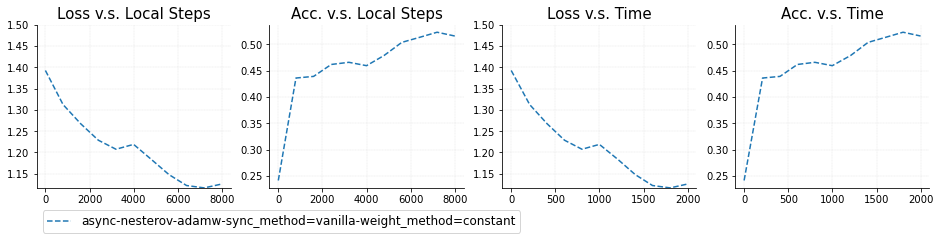

In [ ]:
exp = AsyncExperiment(outer_opt_name=outer_opt_name,
                      outer_opt_kwargs=outer_opt_kwargs,
                      inner_opt_name=inner_opt_name,
                      inner_opt_kwargs=inner_opt_kwargs,
                      max_wait_time=max_wait_time,
                      verbose=verbose,
                      eval_every=eval_every,
                      total_phases=total_phases,
                      sync_method=sync_method)
exp.run()
plot_results([exp])

# Experiments

### Visualization of the Dataset

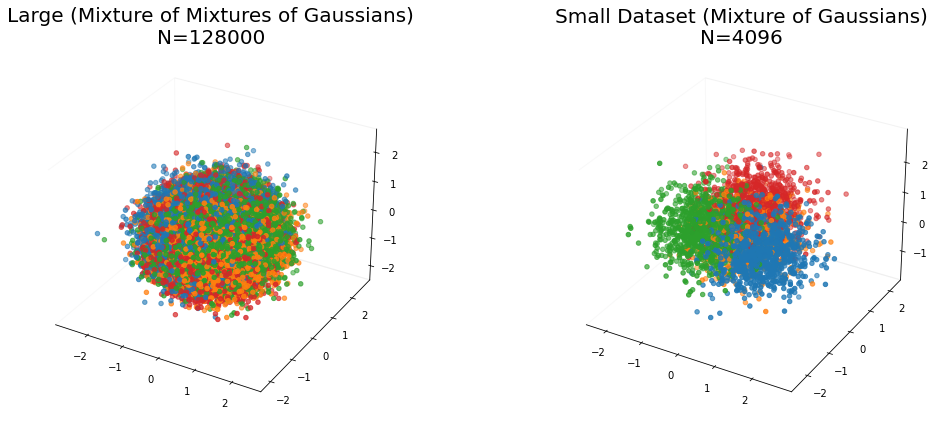

In [ ]:
plot_svd()

### Sanity Check


[info] Starting experiment sync-sgd-adamw ...
[info] step      0 | time       0.00 | acc 0.24 | loss 1.392653
[info] step     80 | time      66.60 | acc 0.34 | loss 1.355827
[info] step    160 | time     133.20 | acc 0.38 | loss 1.325739
[info] step    240 | time     199.80 | acc 0.40 | loss 1.309252
[info] step    320 | time     266.40 | acc 0.41 | loss 1.302016
[info] step    400 | time     333.00 | acc 0.40 | loss 1.302908

[info] Starting experiment sync-sgd-adamw ...
[info] step      0 | time       0.00 | acc 0.24 | loss 1.392653
[info] step     80 | time      66.60 | acc 0.34 | loss 1.355827
[info] step    160 | time     133.20 | acc 0.38 | loss 1.325739
[info] step    240 | time     199.80 | acc 0.40 | loss 1.309252
[info] step    320 | time     266.40 | acc 0.41 | loss 1.302016
[info] step    400 | time     333.00 | acc 0.40 | loss 1.302908

[info] Starting experiment async-sgd-adamw-sync_method=delayed_sgd-weight_method=constant ...
[info] step      0 | time       0.00 | acc 

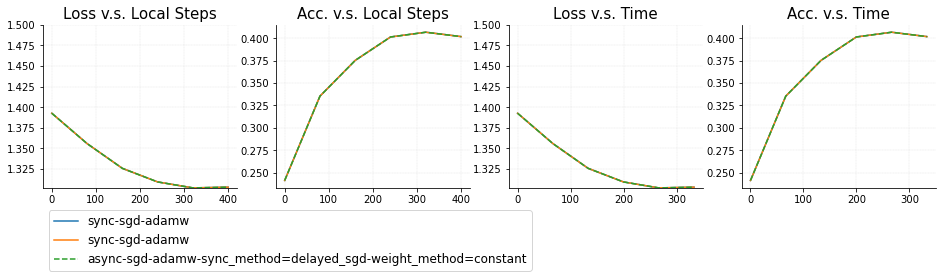

In [ ]:
outer_opt_name='sgd'
outer_opt_kwargs = dict(
    lr=0.5,
    momentum=0.0,
)

sync_exp  = SyncExperiment(outer_opt_name=outer_opt_name,
                           outer_opt_kwargs=outer_opt_kwargs,
                           verbose=True,
                           eval_every=1,
                           total_phases=5)
sync_exp.run()

sync_exp2 = SyncExperiment(outer_opt_name=outer_opt_name,
                           outer_opt_kwargs=outer_opt_kwargs,
                           verbose=True,
                           eval_every=1,
                           total_phases=5)
sync_exp2.run()

async_exp = AsyncExperiment(outer_opt_name=outer_opt_name,
                            outer_opt_kwargs=outer_opt_kwargs,
                            max_wait_time=1000.0,
                            verbose=True,
                            eval_every=1,
                            total_phases=5,
                            sync_method='delayed_sgd')
async_exp.run()
plot_results([sync_exp, sync_exp2, async_exp])

### LR Grid Search


[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment sync-nesterov-adamw ...


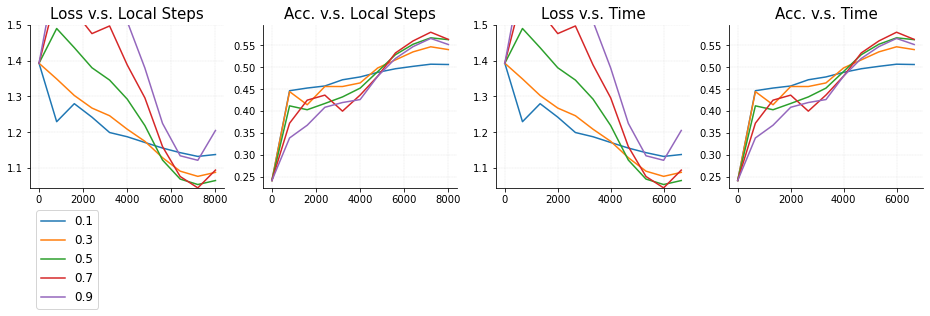

In [ ]:
exps = []
lrs = [0.1, 0.3, 0.5, 0.7, 0.9]
for lr in lrs:
  exp = SyncExperiment(outer_opt_kwargs=dict(lr=lr, momentum=0.9), total_phases=100)
  exp.run()
  exps.append(exp)

plot_results(exps, [str(lr) for lr in lrs])


[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...


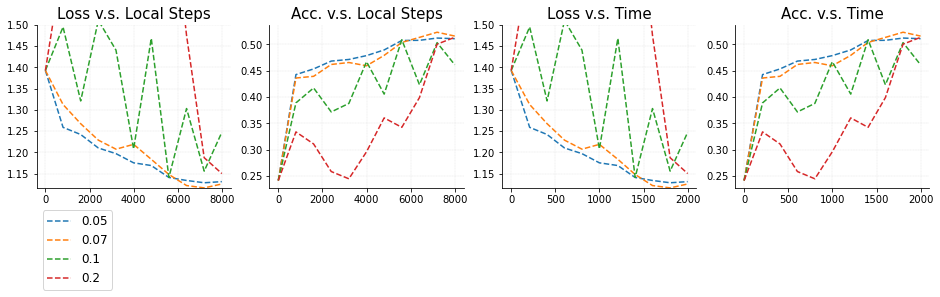

In [ ]:
async_exps = []
lrs = [0.05, 0.07, 0.1, 0.2]
for lr in lrs:
  exp = AsyncExperiment(outer_opt_kwargs=dict(lr=lr, momentum=0.9), total_phases=100)
  exp.run()
  async_exps.append(exp)

plot_results(async_exps, [str(lr) for lr in lrs])

### Sync. v.s. Async Training




[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...


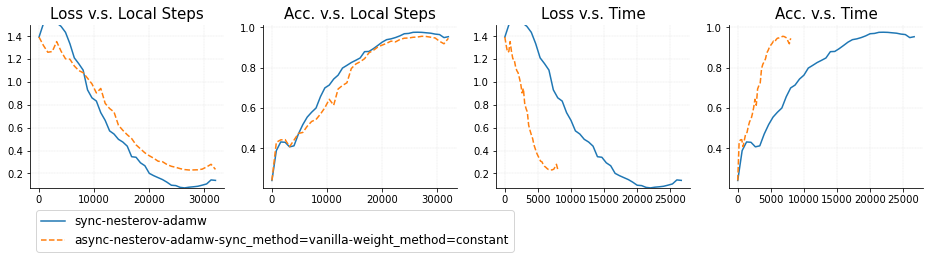

In [ ]:
sync_exp = SyncExperiment(outer_opt_kwargs=dict(lr=0.7, momentum=0.9),
                          total_phases=400)
sync_exp.run()
async_exp = AsyncExperiment(outer_opt_kwargs=dict(lr=0.07, momentum=0.9),
                            total_phases=400)
async_exp.run()
plot_results([sync_exp, async_exp])

### Shorter Training Phases (1 pass of the entire dataset, closer to language modeling)


[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...


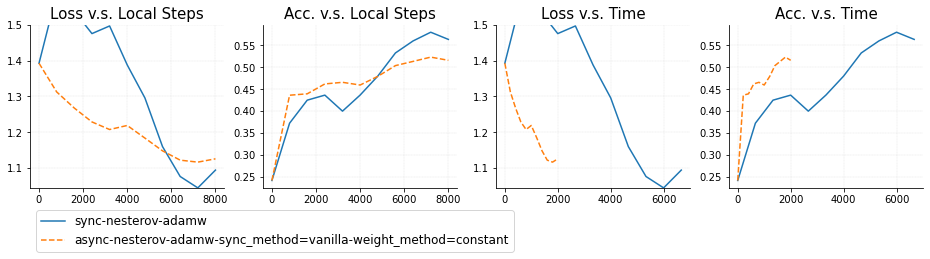

In [ ]:
sync_exp_short = SyncExperiment(outer_opt_kwargs=dict(lr=0.7, momentum=0.9),
                          total_phases=100)
sync_exp_short.run()
async_exp_short = AsyncExperiment(outer_opt_kwargs=dict(lr=0.07, momentum=0.9),
                            total_phases=100)
async_exp_short.run()
plot_results([sync_exp_short, async_exp_short])

### AdamW + SGD (no momentum on the outer loop) - (Async better)


[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...


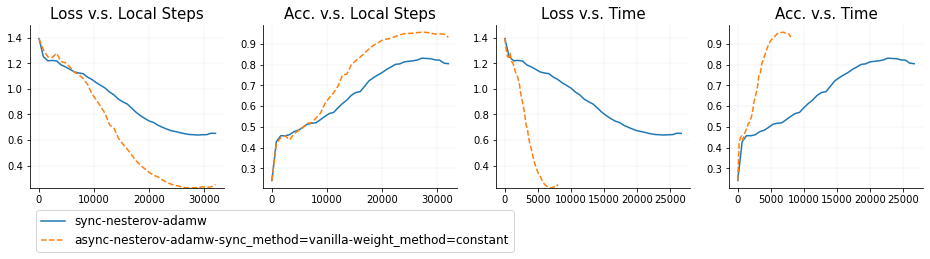

In [ ]:
sync_exp_no_momentum = SyncExperiment(outer_opt_kwargs=dict(lr=0.7, momentum=0.0),
                                      default_inner_steps=20,
                                      total_phases=400)
sync_exp_no_momentum.run()
async_exp_no_momentum = AsyncExperiment(outer_opt_kwargs=dict(lr=0.7, momentum=0.0),
                                        default_inner_steps=20,
                                        total_phases=400)
async_exp_no_momentum.run()
plot_results([sync_exp_no_momentum, async_exp_no_momentum])

### Visualization of Pseudogradients


[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...


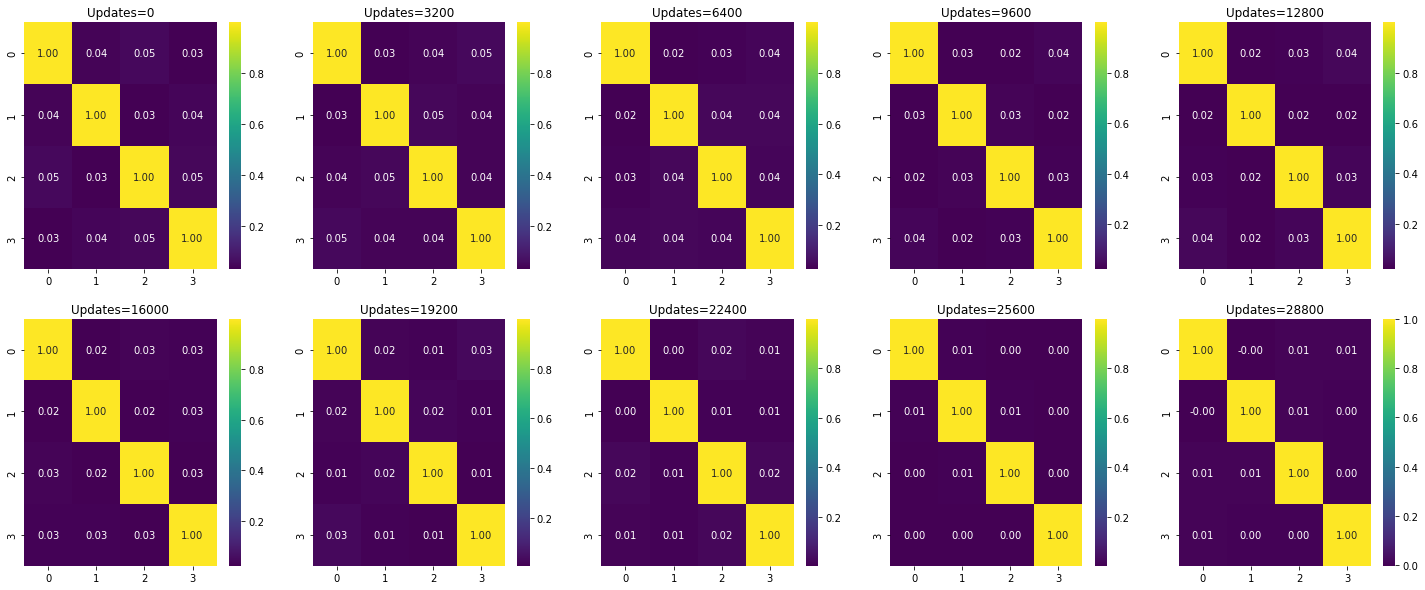

In [ ]:
# model_hidden_size is large and dataset is large (=> pseudogradients are orthogonal throughout training)
sync_exp_cossims = SyncExperiment(outer_opt_kwargs=dict(lr=0.7, momentum=0.9),
                                  record_cossim_every=40,
                                  total_phases=400,
                                  record_cossim=True)
sync_exp_cossims.run()
async_exp_cossims = AsyncExperiment(outer_opt_kwargs=dict(lr=0.07, momentum=0.9),
                                    total_phases=400)
async_exp_cossims.run()
cossims = sync_exp_cossims.cossims
plot_cossims(cossims, 2, 5)

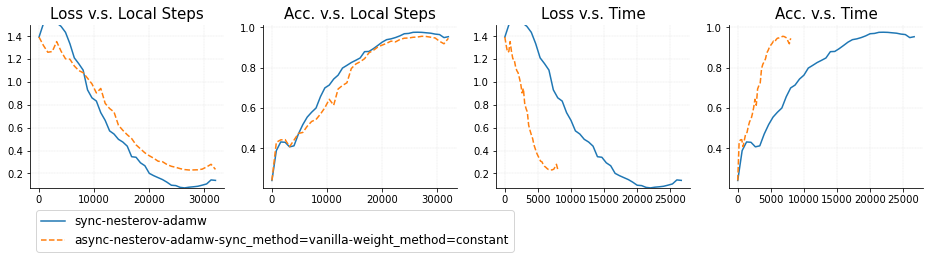

In [ ]:
plot_results([sync_exp_cossims, async_exp_cossims])


[info] Starting experiment sync-nesterov-adamw ...

[info] Starting experiment async-nesterov-adamw-sync_method=vanilla-weight_method=constant ...


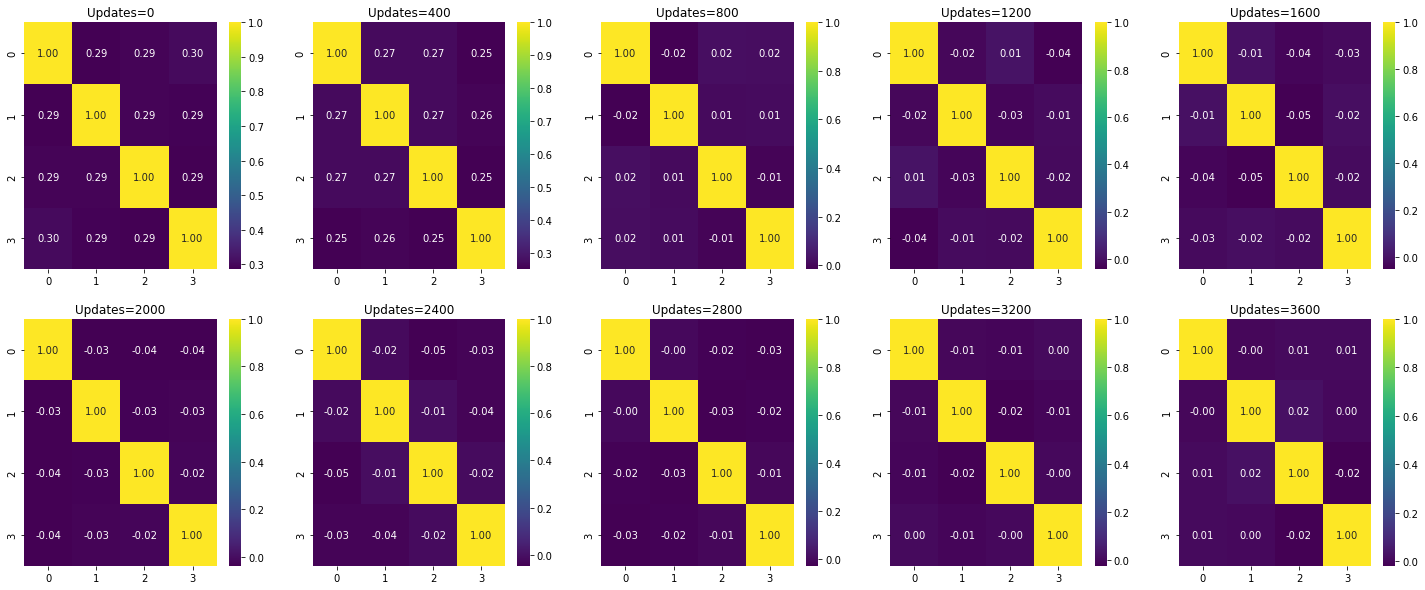

In [ ]:
# model_hidden_size is small and dataset is small with fewer clusters per class (=> pseudogradients are more correlated at the beginning, and gradually shift to be orthogonal)
sync_exp_cossims_small = SyncExperiment(outer_opt_kwargs=dict(lr=1.0, momentum=0.9),
                                  total_phases=50,
                                  record_cossim_every=5,
                                  record_cossim=True,
                                  model_hidden_size=128,
                                  data_mode='small')
sync_exp_cossims_small.run()
async_exp_cossims_small = AsyncExperiment(outer_opt_kwargs=dict(lr=1.0, momentum=0.9),
                                    total_phases=50,
                                    model_hidden_size=128,
                                    data_mode='small')
async_exp_cossims_small.run()
cossims_small = sync_exp_cossims_small.cossims
plot_cossims(cossims_small, 2, 5)

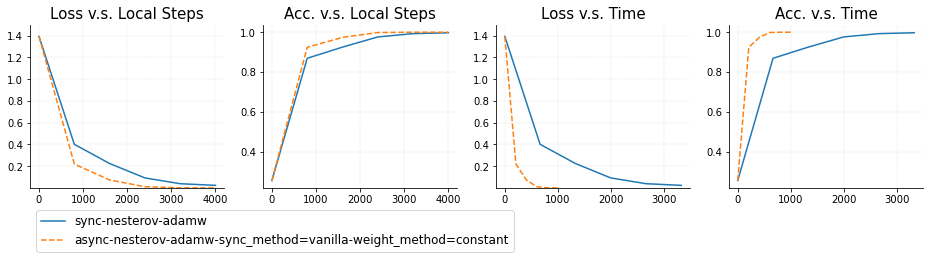

In [ ]:
plot_results([sync_exp_cossims_small, async_exp_cossims_small])